### 네이버에서 크롤링한 영화리뷰 데이터를 이용한 긍부정 분석
- 네이버 영화리뷰를 크롤링
- 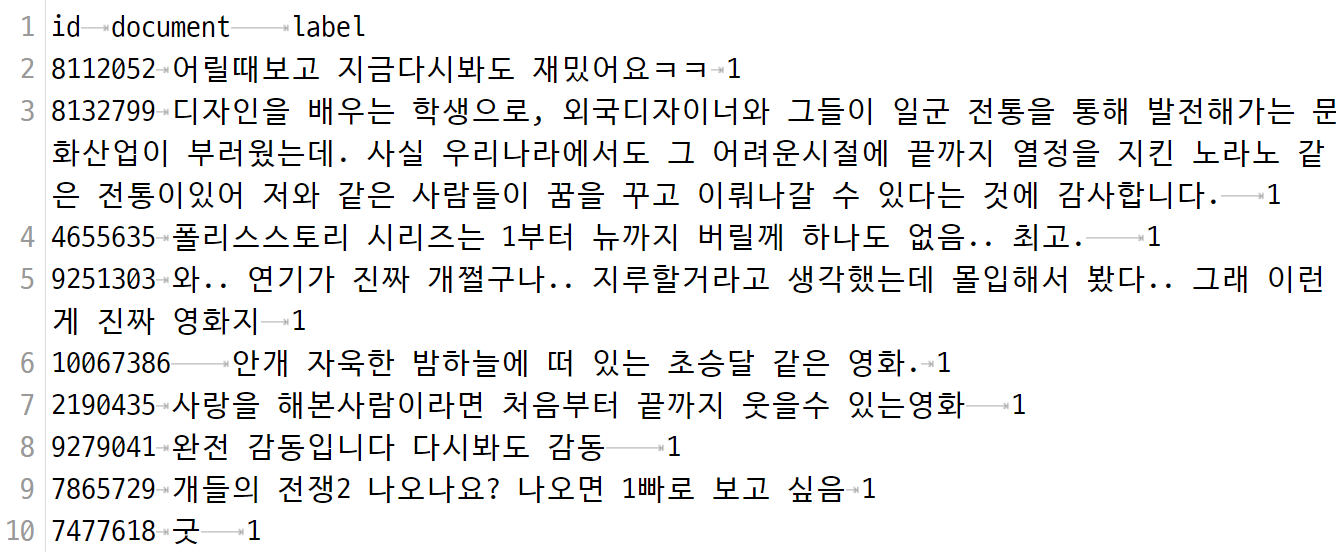
- 평점이 5 초과면 긍정리뷰, 이하면 부정리뷰로 정하고
    - 긍정리뷰 75000 부정리뷰 75000개 수집
- 데이터구성
    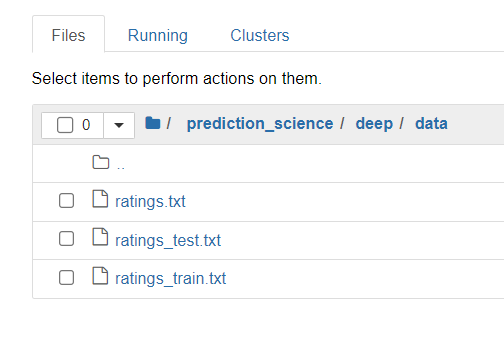

### 리뷰 시각화
- 크롤링한 리뷰 텍스트를 워드 크라우드로 시각화하여 자주 나오는 단어를 확인

In [1]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

URLError: <urlopen error unknown url type: https>

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#트레인 파일 불러오기
train_data = pd.read_csv('ratings_train.txt',header = 0, delimiter = '\t', quoting=3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
print('학습데이터 전체 개수: {}'.format(len(train_data)))

학습데이터 전체 개수: 150000


In [6]:
#리뷰 문자길이 확인
train_length = train_data['document'].astype(str).apply(len)
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

In [7]:
#리뷰 통계 정보
print('리뷰 길이 최댓값: {}'.format(np.max(train_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간값: {}'.format(np.median(train_length)))
print('리뷰 길이 제1사분위: {}'.format(np.percentile(train_length,25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(train_length,75)))

리뷰 길이 최댓값: 158
리뷰 길이 최솟값: 1
리뷰 길이 평균값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간값: 27.0
리뷰 길이 제1사분위: 16.0
리뷰 길이 제3사분위: 42.0


- 리뷰의 평균길이는 35.24
- 중간값과 차이가 있고 편차가 29정도인걸 보면 리뷰길이의 범위가 차이가 많이 남

### 워드크라우드 작성

- 워드크라우드를 보면 그냥, 진짜, 정말 등 강조어등이 자주 나타나는것을 확인할 수 있음

In [8]:
#긍정 1, 부정 0
print('긍정 리뷰 갯수: {}'.format(train_data['label'].value_counts()[1]))
print('부정 리뷰 갯수: {}'.format(train_data['label'].value_counts()[0]))

긍정 리뷰 갯수: 74827
부정 리뷰 갯수: 75173


### 긍/부정 분석을 위한 자연처 처리
- 문자열 데이터를 수치화 하기 위한 작업

### 데이터 전처리

- 5단계로 진행

1. 정규화로 한국어만 남기기

2. 형태소 분석기로 어간 추출하기

3. 불용어 제거하기

4. 문자를 인덱스벡터로 전환하기

5. 패딩처리하기

- 한국어 텍스트를 전처리할 때는 konlpy의 okt()를 사용하여 형태소 분석
    - okt()는 트위터사에서 제작한 한글 형태소 분석기

In [9]:
# !pip install konlpy

In [16]:
import konlpy

In [11]:
import numpy as np
import pandas as pd
import re
import json
# 한글 형태소 분석기 okt 사용
# open korean text 형태소 분석기(트위터에서 제작한것을 이어받아 진행하고 있는 프로젝트)
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
train_data = pd.read_csv('ratings_train.txt', header = 0, delimiter='\t', quoting=3)
train_data['document'][:5]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

1. 전처리 함수 생성
- 한글과 공백제외 모두제거
    - [^가-힣ㄱ-ㅎㅏ-ㅣ\\s] 한글과 공백문자 제외 정규식
    - 가-힣, ㄱ-ㅎ, ㅏ-ㅣ, \s(공백)
- 불용어 제거

In [13]:
import re # 정규식 함수
# sub() : 어떠한 패턴을 특정 문자열로 대체
# 한글 가~힣(모든 한글 글자)
# 한글 자음
# 한글 모음 을 제외한 나머지 글자는 공백으로 대체
re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', ' ', '가나다 abcde ^&### 1234 무직')

'가나다                  무직'

- 위 결과를 보면 한글이 아닌 영문과 특수문자는 공백으로 대체 됨

2. 전체 학습데이터 및 평가데이터 리뷰 전처리하기

In [14]:
review = '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정'
#  1. 한글 및 공백 제외한 문자 모두 제거
review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', ' ', review)
review_text

'교도소 이야기구먼   솔직히 재미는 없다  평점 조정'

### 한글 형태소 단위 토크나이징
- KoNLPy 사용
    - KoNLPy에서는 여러 형태소 분석기를 제공하며, 각 형태소 분석기별로 분석한 결과는 다를 수 있다.
    - 각 형태소 분석기는 클래스 형태로 되어 있고 이를 객체로 생성한 후 매서드를 호출해서 토크나이징할 수 있다.

- 형태소 분석 및 품사 태깅
    - 형태소란 의미를 가지는 가장 작은 단위로서 더 쪼개지면 의미를 상실하는 것들을 말한다.
    - 형태소 분석이란 의미를 가지는 단위를 기준으로 문장을 살펴보는 것을 의미한다.
    - KoNLPy는 기존에 C, C++, Java 등의 언어를 통해 형태소 분석을 할 수 있는 좋은 라이브러리들을 파이썬 라이브러리로 통합해서 사용할 수 있록 하여 한국어 구문 분석을 쉽게 할 수 있도록 만들어진 라이브러리이다.
    - KoNLPy에는 다양한 형태소 분석기들이 객체 형태로 포함돼 있으며 다음과 같은 각 형태소 분석기 목록이 있다.
        - Hannanum
        - Kkma
        - Komoran
        - Mecab
        - Okt(Twitter)
        - 모두 동일한 형태소 분석 기능 제공하지만 각기 성능이 조금씩 다름

- Okt 사용
    1. 객체 생성
        - Okt() 생성자 함수 이용
    2. 필요 함수 사용
    - okt.morphs() 텍스트를 형태소 단위로 나눈다. 옵션으로 norm과 stem이 있다. norm은 문장을 정규화. stem은 각 단어에서 어간을 추출.(기본값은 둘다 False)
    - okt.nouns() 텍스트에서 명사만 뽑아낸다.
    - okt.phrases() 텍스트에서 어절을 뽑아낸다.
    - okt.pos() 각 품사를 태깅하는 역할을 한다. 품사를 태깅한다는 것은 주어진 텍스트를 형태소 단위로 나누고, 나눠진 각 형태소를 그에 해당하는 품사와 함께 리스트화하는 것을 의미한다. 옵션으로 norm, stem, join이 있는데 join은 나눠진 형태소와 품사를 ‘형태소/품사’ 형태로 같이 붙여서 리스트화한다.

In [15]:
from konlpy.tag import Okt
#2. okt 객체를 활용하여 형태소 단어로 나눔
okt = Okt()
word_review = okt.morphs(review_text, stem = True)
word_review

['교도소', '이야기', '구먼', '솔직하다', '재미', '는', '없다', '평점', '조정']

## okt 에러 발생 시 java 설치
- No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.
- java 다운로드
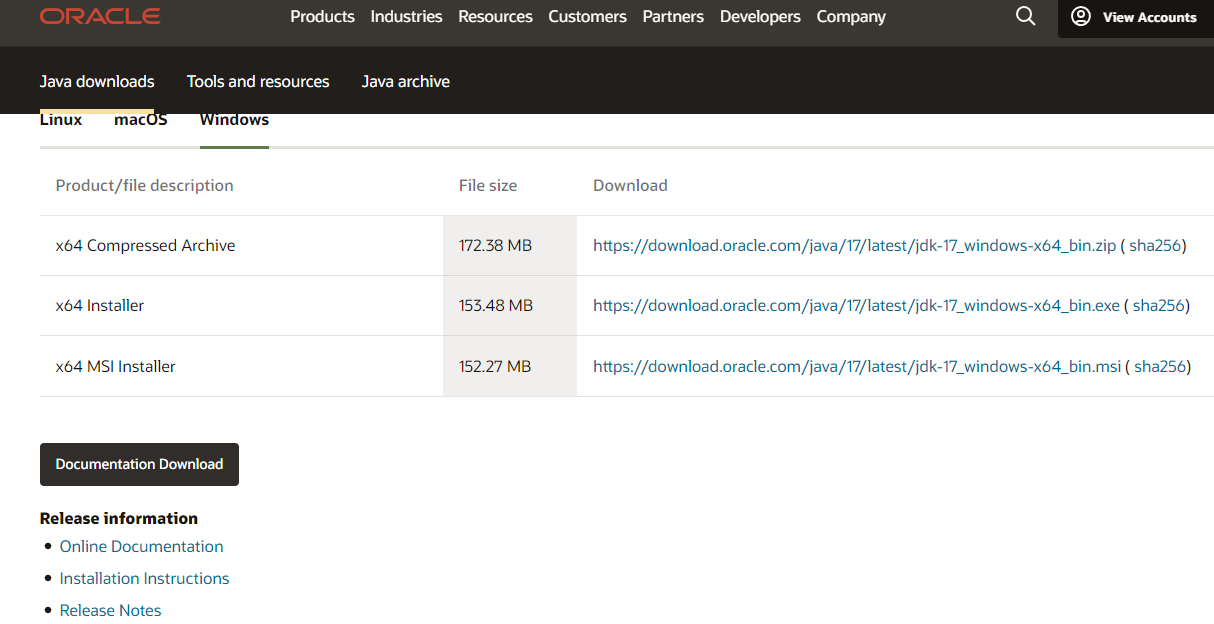
- 설치 후 java_home 등록
    - 환경변수 편집
    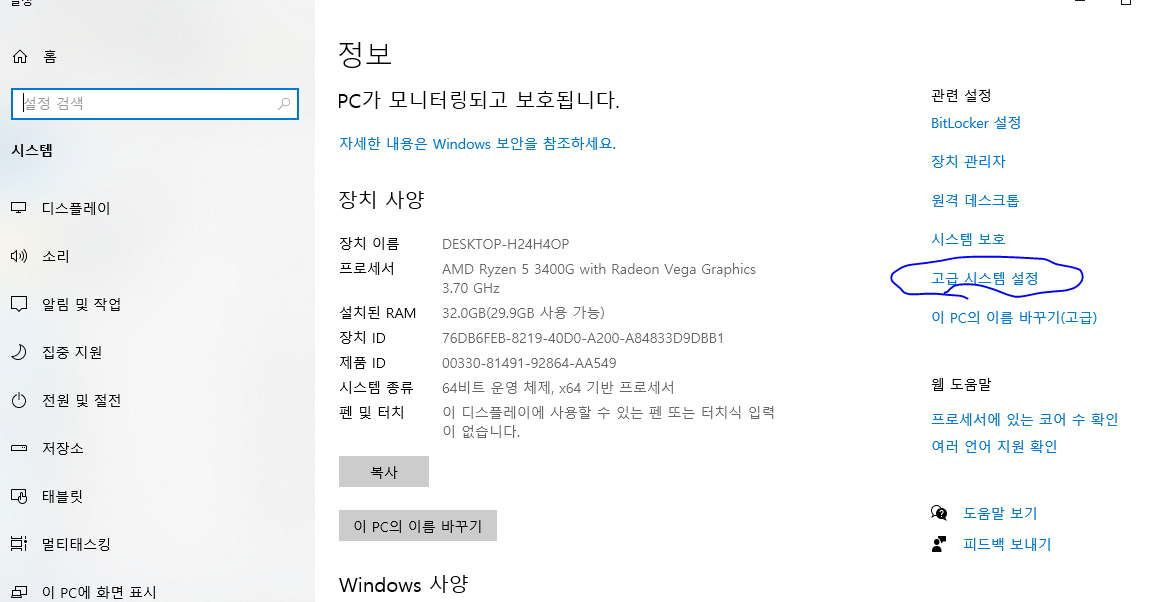
    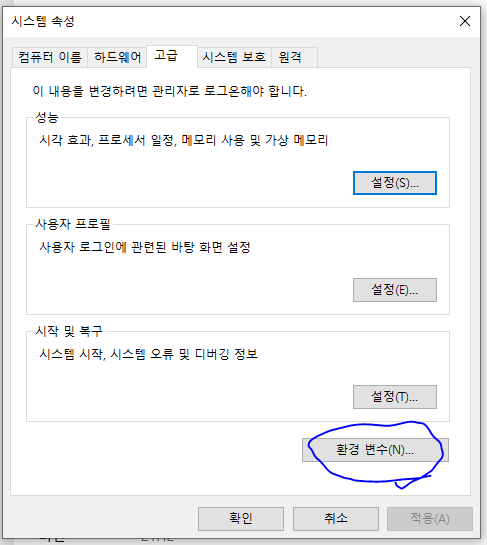
    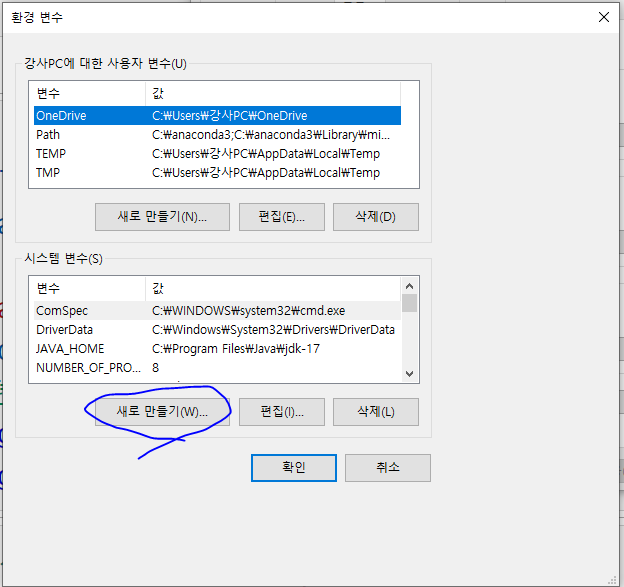
    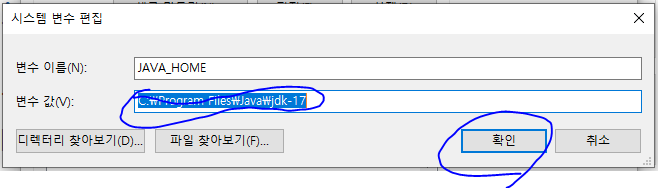
    - 변수값 : 본인 jdk 설치 디렉터리

In [17]:
# 3. stop_words 제거
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
s_lis = [token for token in word_review if not token in stop_words]
s_lis

['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']

In [23]:
# 4. 추출된 형태소에서 불용어 제거한 토큰을 word index로 변환
# 케라스의 Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(s_lis)
t_seq = tokenizer.texts_to_sequences(s_lis)
t_seq = np.reshape(t_seq, (1, -1))
t_seq

array([[1, 2, 3, 4, 5, 6, 7, 8]])

In [30]:
tokenizer.word_index

{'교도소': 1, '이야기': 2, '구먼': 3, '솔직하다': 4, '재미': 5, '없다': 6, '평점': 7, '조정': 8}

In [31]:
#5. Tokenizer가 생성한 단어사전은 저장해야 테스트데이터와 예측진행 시 사용할 수 있음
word_vocab = tokenizer.word_index
MAX_SEQUENCE_LENGTH = 10 #문장 최대 길이

#학습 데이터
train_inputs = pad_sequences(t_seq, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
train_inputs

array([[1, 2, 3, 4, 5, 6, 7, 8, 0, 0]])

### 위 과정을 모두 처리하는 전처리 함수 만들기

In [32]:
#전처리 함수 만들기
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
    #함수인자설명
    # review: 전처리할 텍스트
    # okt: okt객체를 반복적으로 생성하지 않고 미리 생성 후 인자로 받음
    # remove_stopword: 불용어를 제거할지 여부 선택. 기본값 False
    # stop_words: 불용어 사전은 사용자가 직접 입력, 기본값 빈 리스트

    # 1. 한글 및 공백 제외한 문자 모두 제거
    review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)
    # review에서 한글및공백을 제외한 문자는 ' '로 치환
    #

    #2. okt 객체를 활용하여 형태소 단어로 나눔
    word_review = okt.morphs(review_text,stem=True)

    if remove_stopwords:
        #3. 불용어 제거
        word_review = [token for token in word_review if not token in stop_words]
    return word_review
# 1개의 review를 전처리하는 함수

In [33]:
# 전체 텍스트 전처리
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
okt = Okt()
clean_train_review = []

In [35]:
for review in train_data['document'][:10000]: # 전처리 및 학습 속도 문제로 10000개 데이터만 사용
  # 리뷰가 문자열인 경우만 전처리 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, True, stop_words))
    else:
        clean_train_review.append([]) #str이 아닌 행은 빈칸으로 놔두기

clean_train_review[:4]

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

In [38]:
#테스트 리뷰도 동일하게 전처리
test_data = pd.read_csv('ratings_test.txt', header = 0, delimiter='\t', quoting=3)

clean_test_review = []
for review in test_data['document'][:10000]:
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, True, stop_words))
    else:
        clean_test_review.append([])
        
clean_test_review[:4]

[['굳다', 'ㅋ'],
 [],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

In [ ]:
clean_test_review # 10000개의 전처리된 리뷰(테트스용) - 2차원 리스트
clean_train_review # 10000개의 전처리된 리뷰(학습용) - 2차원 리스트

3. 문자로 되어있는 리뷰데이터를 인덱스 벡터로 변환
- 학습데이터 리뷰로 단어 사전을 생성하여 리뷰데이터를 인덱스로 바꾸어 주도록 하겠습니다.

- 라벨데이터(긍정, 분석 감정데이터, 정답 데이터)는 벡터화 해줍니다.

In [40]:
# 인덱스 벡터 변환 후 일정 길이 넘어가거나 모자라는 리뷰 패딩처리
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review) # 학습데이터로 단어사전을 생성(word_index)
train_sequences = tokenizer.texts_to_sequences(clean_train_review) # 학습데이터를 숫자 seq로 변환
test_sequences = tokenizer.texts_to_sequences(clean_test_review) # 테스트데이터를 숫자 seq로 변환
# 테스트데이터 및 예측 데이터, 새로운 리뷰 등도 모두 학습데이터로 만들어진 단어사전을 이용해 숫자 seq로 변환

In [44]:
word_vocab = tokenizer.word_index #단어사전형태
MAX_SEQUENCE_LENGTH = 8 #문장 최대 길이
#학습 데이터
train_inputs = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
#학습 데이터 라벨 벡터화
train_labels = np.array(train_data['label'])
train_inputs[0]

array([679,  20, 235, 824,   0,   0,   0,   0])

In [45]:
#평가 데이터
test_inputs = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
#평가 데이터 라벨 벡터화
test_labels = np.array(test_data['label'])

4. 전처리 완료된 데이터 넘파이 파일로 저장
- 여기서 만들어준 데이터들을 학습시 사용이 용이하도록 넘파이 파일로 만들어 저장

In [47]:
DATA_PATH = 'cleandata/' #.npy파일 저장 경로지정,  #없으면 생성
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json' # word_vocab 단어사전 저장 파일명

data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) + 1

In [52]:
data_configs.keys()
data_configs

{'vocab': {'영화': 1,
  '하다': 2,
  '보다': 3,
  '에': 4,
  '을': 5,
  '도': 6,
  '를': 7,
  '없다': 8,
  '이다': 9,
  '있다': 10,
  '좋다': 11,
  '다': 12,
  '정말': 13,
  '너무': 14,
  '재밌다': 15,
  '만': 16,
  '같다': 17,
  '되다': 18,
  '적': 19,
  '진짜': 20,
  '아니다': 21,
  '으로': 22,
  '점': 23,
  '로': 24,
  '않다': 25,
  '에서': 26,
  '나오다': 27,
  '과': 28,
  '연기': 29,
  '평점': 30,
  '만들다': 31,
  '최고': 32,
  '안': 33,
  '나': 34,
  '인': 35,
  '내': 36,
  '그': 37,
  '못': 38,
  '사람': 39,
  '스토리': 40,
  '드라마': 41,
  '왜': 42,
  '보고': 43,
  '게': 44,
  '고': 45,
  '생각': 46,
  '감동': 47,
  '아깝다': 48,
  '말': 49,
  '때': 50,
  '이렇다': 51,
  '감독': 52,
  'ㅋㅋ': 53,
  '시간': 54,
  '그냥': 55,
  '배우': 56,
  '재미없다': 57,
  '거': 58,
  '더': 59,
  '요': 60,
  '내용': 61,
  '재미': 62,
  '하고': 63,
  '재미있다': 64,
  '와': 65,
  '지루하다': 66,
  '자다': 67,
  '가다': 68,
  '주다': 69,
  '네': 70,
  '뭐': 71,
  '모르다': 72,
  '중': 73,
  '까지': 74,
  '좀': 75,
  '들다': 76,
  '쓰레기': 77,
  '작품': 78,
  '알다': 79,
  '그렇다': 80,
  '지': 81,
  '하나': 82,
  '사랑': 83,
  '싶다': 84,
  '이건

In [53]:
#전처리한 데이터들 파일로저장
import os

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

#전처리된 학습데이터 넘파이로 저장
np.save(open(DATA_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
#전처리된 테스트데이터 넘파이로 저장
np.save(open(DATA_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

#데이터 사전 json으로 저장
json.dump(data_configs, open(DATA_PATH + DATA_CONFIGS, 'w'), ensure_ascii = False)

### 데이터 사전
- 단어와 매칭되는 라벨코드
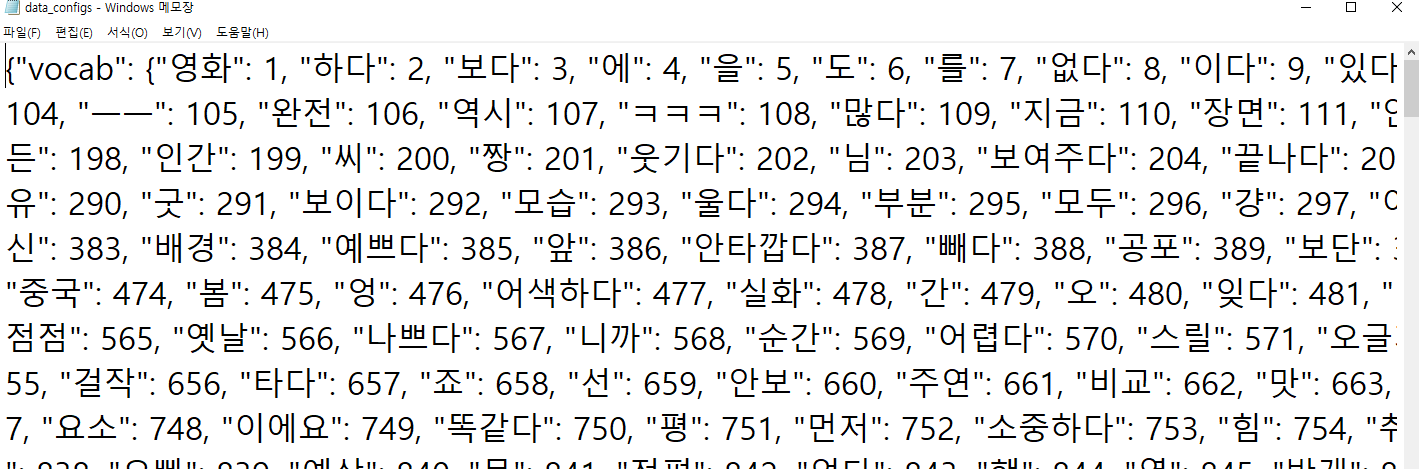

- 저장된 numpy로 변환된 학습/테스트 데이터 불러오기

In [54]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

#전처리 데이터 불러오기
DATA_PATH = 'cleandata/'
DATA_OUT = 'data_out/' # 없으면 생성
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [59]:
train_input = np.load(open(DATA_PATH + INPUT_TRAIN_DATA,'rb'))
train_input[0]

array([679,  20, 235, 824,   0,   0,   0,   0])

In [60]:
train_label = np.load(open(DATA_PATH + LABEL_TRAIN_DATA,'rb'))
prepro_configs = json.load(open(DATA_PATH+DATA_CONFIGS,'r'))

In [61]:
train_input[0] # 4개 단어가 남은 리뷰 8개로 맞춰야 하므로 모자란건 0으로 채움
train_input[1] # 전처리 후 남은 리뷰 단어가 >=8 인 리뷰

array([ 652,    1,  176, 1727,   29,  951,  720,   25])

In [62]:
 # 이 리뷰는 문장값이 682,20,241,776인 리뷰임
 # 이 수치에 대응하는 단어는 json파일로 저장했고 prepro_configs변수에 load 했음

In [66]:
# 숫자에 대응되는 단어 확인하기 위해 prepro_configs['vocab']의 key, value 뒤집기
tmp_dict = dict(map(reversed,prepro_configs['vocab'].items()))
# tmp_dict

In [67]:
for vl in train_input[0][:4] :
    print(tmp_dict[vl])

더빙
진짜
짜증나다
목소리


In [68]:
for vl in train_input[1] :
    print(tmp_dict[vl])

초딩
영화
줄
오버
연기
조차
가볍다
않다


### 모델 구성
- tensorflow.keras.Model 상속받아서
    - 사용자 정의 모델 클래스 구현

In [49]:
prepro_configs.keys()
# 'vocab' : 단어사전
# 'vocab_size' : 단어사전크기

dict_keys(['vocab', 'vocab_size'])

In [69]:
vocab_size = prepro_configs['vocab_size'] # 단어사전 크기
embbeding_size = 128,
vocab_size

12352

## CNN으로 모델 생성
- Conv1D : 이미지등 2차원 데이터가 아닌 문장 같은 1차원의 sequential 데이터에 cnn 적용할 때 사용하는 함수
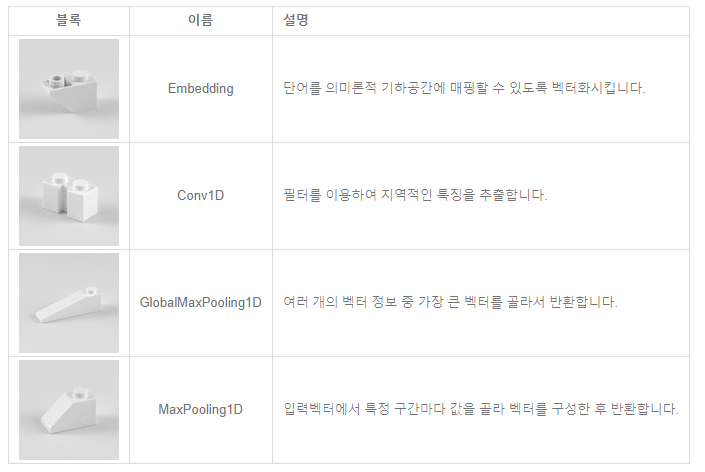

tf.keras.layers.Conv1D(
    filters,
    kernel_size,
    strides=1,
    padding='valid',
    data_format='channels_last',
    dilation_rate=1,
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding

In [71]:
model = Sequential()
# 128 크기의 벡터 생성
model.add(Embedding(vocab_size, 128))
# 1차원의 sequential 데이터에 cnn 적용  CONV1d 사용
model.add(tf.keras.layers.Conv1D(100, 5, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(250, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
             loss = 'binary_crossentropy', # 긍부정이므로 이진 분류
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1581056   
                                                                 
 conv1d (Conv1D)             (None, None, 100)         64100     
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 250)               25250     
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                        

<hr/>

In [72]:
from tensorflow.keras.models import save_model

In [73]:
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1 # 학습데이터에서 저장 비율만큼 분리해서 val_data로 사용
MAX_LEN = train_input.shape[1]
model_name = 'naver'

In [99]:
#검증 정확도를 통한 EarlyStopping 기능 및 모델 저장 방식 지정

checkpoint_path = DATA_OUT + model_name +'\weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))



data_out/naver -- Folder already exists 



In [100]:
earlystop_callback = EarlyStopping(monitor = 'val_accuracy', patience = 2)
cp_callback = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',
                              save_best_only = True, save_weights_only = True)

- validation_split 파라미터 : 주어진 학습데이터에서 파라미터에 저장된 비율만큼 분리해서 val_data를 생성해서 검증손실 계산하게 됨

In [101]:
history = model.fit(train_input, 
                    train_label, 
                    batch_size = BATCH_SIZE, 
                    epochs = NUM_EPOCHS,
                    validation_split = VALID_SPLIT, 
                    callbacks = [earlystop_callback, cp_callback])
# 모델 저장하기

Epoch 1/10
26/26 [==============================] - 1s 22ms/step - loss: 0.3865 - accuracy: 0.7867 - val_loss: 0.9144 - val_accuracy: 0.5162
Epoch 2/10
26/26 [==============================] - 1s 20ms/step - loss: 0.3739 - accuracy: 0.7911 - val_loss: 0.9325 - val_accuracy: 0.5183
Epoch 3/10
26/26 [==============================] - 1s 20ms/step - loss: 0.3655 - accuracy: 0.7919 - val_loss: 0.9479 - val_accuracy: 0.5197
Epoch 4/10
26/26 [==============================] - 0s 19ms/step - loss: 0.3608 - accuracy: 0.7940 - val_loss: 0.9708 - val_accuracy: 0.5204
Epoch 5/10
26/26 [==============================] - 1s 19ms/step - loss: 0.3538 - accuracy: 0.7950 - val_loss: 0.9930 - val_accuracy: 0.5225
Epoch 6/10
26/26 [==============================] - 1s 20ms/step - loss: 0.3517 - accuracy: 0.7976 - val_loss: 0.9899 - val_accuracy: 0.5162
Epoch 7/10
26/26 [==============================] - 1s 20ms/step - loss: 0.3418 - accuracy: 0.8002 - val_loss: 1.0260 - val_accuracy: 0.5119


In [109]:
model.save('./model/review.h5')

In [ ]:
- 학습 손실과 검증 손실의 차이가 많이 보임
    - 학습 손실이 검증 손실에 비해 상대적으로 매우 작기때문에 과소적합으로 보임
    - 10번보다 더 많은 학습을 진행하고 조기종료 조건도 더높일필요가 있어보임

## 평가하기

In [78]:
##  전처리한 test data load
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'


test_input = np.load(open(DATA_PATH+INPUT_TEST_DATA,'rb'))
# 패딩처리
test_input = pad_sequences(test_input,maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_PATH + LABEL_TEST_DATA, 'rb'))

In [104]:
model.load_weights('./model/review.h5') # 저장된 모델을 로드해서 사용
model.evaluate(test_input, test_label_data[:10000])

313/313 [==============================] - 1s 2ms/step - loss: 0.8351 - accuracy: 0.6044


[0.8350645303726196, 0.6043999791145325]

- 현재 데이터는 리뷰의 일부만 사용중임
    - 전체 데이터로 늘리면 더 좋은 성능을 기대할 수 있음

In [105]:
test_input[0]

array([1401,   89,    0,    0,    0,    0,    0,    0])

## 예측하기

In [106]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

In [107]:
# 모델 불러오기
# model = tf.keras.models.load_model('./model/review.h5') # ./model.review.h5


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xec in position 32: invalid continuation byte

### 학습 후 완성된 모델을 저장했다고 가정하면
- 새로 입력될 텍스트의 전처리에는
    - 학습에 사용된 텍스트 전처리 모듈을 그대로 적용해 줘야 함
    - **특히 토크나이저는 학습에서 사용된 단어 index를 그대로 사용해야 함**

In [87]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
okt = Okt()
tokenizer  = Tokenizer()

# 학습에서 사용한 단어 인덱스 불러오기
DATA_CONFIGS = 'cleandata/data_configs.json'
prepro_configs = json.load(open(DATA_CONFIGS,'r'))
prepro_configs['vocab_size']

12352

In [58]:
word_vocab = prepro_configs['vocab']
# print(word_vocab)
# 새로 tokenizer를 진행하는 것이 아닌 기존에 만든 tokenizer의 형태를 그대로
# 사용해야 하므로 위에서 만들어 저장 해 놓은 word index를 가져와서
# tokenizer를 구성
# fit_on_texts()
tokenizer.fit_on_texts(word_vocab)

In [11]:
import itertools
import tensorflow as tf

In [111]:
MAX_LENGTH = 8 #문장최대길이

sentence = input('감성분석할 문장을 입력해 주세요.: ')

# 새로 입력된 문장을 전처리
sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\\s ]','', sentence)
stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한'] # 불용어 추가할 것이 있으면 이곳에 추가
sentence = okt.morphs(sentence, stem=True) # 토큰화
sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
print(sentence)

vector  = tokenizer.texts_to_sequences(sentence)
# vector = np.reshape(vector_t,(1,-1))
pad_new = pad_sequences([vector], maxlen = MAX_LENGTH,padding='post') # 패딩
model = tf.keras.models.load_model('./model/review.h5')
# print(pad_new)
predictions = model.predict(pad_new)
print(predictions)
predictions = float(predictions)

if(predictions > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(predictions * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - predictions) * 100))

감성분석할 문장을 입력해 주세요.: 이거 재밌네
['거', '재밌다']


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xec in position 32: invalid continuation byte